In [1]:
!nvidia-smi

Thu Jun 22 14:34:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:AF:00.0 Off |                  N/A |
| 27%   29C    P8    18W / 250W |  10790MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:D8:00.0 Off |                  N/A |
| 27%   

In [2]:
import os
import shutil
import scipy
from scipy import stats
from skimage.io import imread, imsave
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
scipy.__version__

'1.3.1'

In [5]:
weights_path='/logs/nissl20230602T0739/mask_rcnn_nissl_1499.h5'

In [6]:
import os
import numpy as np
from PIL import Image
from math import floor
def tile_image(image,sz=512):
    fileExt='jp2'
    h,w,c=image.shape
    tiles={}
    for row in range(0, h, sz):
        for col in range(0, w, sz):
            tile = image[row:min(row + sz, h), col:min(col + sz, w), :]
#             maskT = mask[row:min(row + sz, w), col:min(col + sz, h)]
            tileName = str(floor(row/sz)+1) + "_" + str(floor(col/sz)+1) + "." + fileExt # fileName w/o fileExtension 
#             print(tileName)
            tiles[tileName]=tile
    return tiles
          
def restitch_tiles(tiles):
    # Extract tile size from the first tile
    first_tile_key = next(iter(tiles))
    first_tile = tiles[first_tile_key]
    tile_size = first_tile.shape[:2]  # Extract height and width dimensions

    # Calculate the dimensions of the original image
    max_row = max_col = 0
    for tile_key in tiles:
        row, col = map(int, tile_key[:-4].split('_')[:2])  # Extract row and column indices
        max_row = max(max_row, row)
        max_col = max(max_col, col)
    w = tile_size[1] * max_col
    h = tile_size[0] * max_row

    # Create an empty array for the restitched image
    restitched_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Iterate over each tile
    for tile_key in tiles:
        tile_array = tiles[tile_key]

        # Extract the tile position from the file name
        row, col = map(int, tile_key[:-4].split('_')[:2])  # Extract row and column indices

        # Calculate the pixel coordinates for the tile
        start_row = (row - 1) * tile_size[0]
        end_row = start_row + tile_array.shape[0]
        start_col = (col - 1) * tile_size[1]
        end_col = start_col + tile_array.shape[1]

        # Insert the tile into the restitched image array
        restitched_image[start_row:end_row, start_col:end_col, :] = tile_array

    # Return the restitched image array
    return restitched_image


In [7]:
from PIL import Image, ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 9105779438


In [8]:
import imagecodecs
import matplotlib.pyplot as plt
start_time=time.time()
image = imagecodecs.imread('/M32/Samik/ImageTiles/MD847-N58-2022.01.12-16.56.22_MD847_1_0172_lossless.jp2')  # Replace "image.jp2" with your file path
read_end_time=time.time()
read_time=(read_end_time-start_time)/ 60
print('Image Reading Time: ',read_time, " minutes.")


Image Reading Time:  21.446340115865073  minutes.


In [9]:
H,W,C=image.shape

In [10]:
print(H,W,C)

41594 50627 3


In [ ]:
plt.imshow(image[:,:,:])
plt.axis('off')  # Optional: Turn off axis labels
plt.show()

In [30]:
tiling_start=time.time()
Tile_dict=tile_image(image)
tiling_end=time.time()
tiling_time=(tiling_end-tiling_start)
print("Image Tiling time: ",tiling_time, " seconds.")


Image Tiling time:  0.04635262489318848  seconds.


In [29]:
print("Total Number of tiles: ",len(Tile_dict.keys()))

Total Number of tiles:  8118


# Running Inference 

In [ ]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.intra_op_parallelism_threads=1
config.inter_op_parallelism_threads=1
set_session(tf.Session(config=config))

In [ ]:
import sys
sys.path.append('../..')
from mrcnn.config import Config
import numpy as np
from mrcnn import model as modellib

In [ ]:
class NucleusConfig(Config):
    """Configuration for training on the nissl segmentation dataset. while using command "train"
    """
    # Give the configuration a recognizable name
    NAME = "nissl"

    # Adjust depending on your GPU memory
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1 # since multiprocessing doesn't work

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cell

    # Number of training and validation steps per epoch
    # 238 is the size of train set
    STEPS_PER_EPOCH = 218 // (IMAGES_PER_GPU * GPU_COUNT)
    VALIDATION_STEPS = max(1, 20 // (IMAGES_PER_GPU * GPU_COUNT))

    # Don't exclude based on confidence. Since we have two classes
    # then 0.5 is the minimum anyway as it picks between nissl and BG
    DETECTION_MIN_CONFIDENCE = 0.7

    # Backbone network architecture
    # Supported values are: resnet50, resnet101
    BACKBONE = "resnet50"

    # Input image resizing
    # Random crops of size 512x512
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (4,8,16,32,64) #(16, 32, 64, 128, 256)

    # Ratios of anchors at each cell (width/height)
    # A value of 1 represents a square anchor, and 0.5 is a wide anchor
    RPN_ANCHOR_RATIOS = [0.5, 1, 2, 4]

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9

    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 1000
    POST_NMS_ROIS_INFERENCE = 2000

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.95

    # How many anchors per image to use for RPN training
    # RPN_TRAIN_ANCHORS_PER_IMAGE = 64

    # Image mean (RGB)
    # setting means for R and G to 0 since cells are mostly blue
    MEAN_PIXEL = np.array([0, 0, 117])

    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution images.
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    IMAGE_CHANNEL_COUNT = 3

    # Number of ROIs per image to feed to classifier/mask heads
    # The Mask RCNN paper uses 512 but often the RPN doesn't generate
    # enough positive proposals to fill this and keep a positive:negative
    # ratio of 1:3. You can increase the number of proposals by adjusting
    # the RPN NMS threshold.
    TRAIN_ROIS_PER_IMAGE = 500 #500 #710#800 #1000#710 #128

    # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 4000

    # Max number of final detections per image
    DETECTION_MAX_INSTANCES = 4000

class NucleusInferenceConfig(NucleusConfig):
    """Test-time configurations. while using command "test" or "detect"
    """
    # Set batch size to 1 to run one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.99

    USE_MINI_MASK = False

In [ ]:
config = NucleusInferenceConfig()
model = modellib.MaskRCNN(mode='inference', config=config, model_dir='/logs')

In [ ]:
model.load_weights(weights_path, by_name=True)

In [ ]:
def get_annotated_cells_img(original_image, annotated_cells):
    # Create a copy of the original image
    display_image = original_image.copy()

    # Iterate over each annotated cell
    for i in range(annotated_cells.shape[2]):
        # Extract the binary annotation for the current cell
        cell_annotation = annotated_cells[:, :, i]

        # Create a boolean mask for the current cell annotation
        cell_mask = np.zeros_like(original_image[:, :, 0])
        cell_mask[cell_annotation > 0] = 255

        # Convert the mask to BGR color space
        cell_mask_bgr = cv2.cvtColor(cell_mask, cv2.COLOR_GRAY2BGR)

        # Set the red channel to maximum intensity (255)
        cell_mask_bgr[:, :, 0][cell_mask == 255] = 255
        cell_mask_bgr[:, :, 1][cell_mask == 255] = 0
        cell_mask_bgr[:, :, 2][cell_mask == 255] = 0
        # Add the cell mask to the display image
        display_image = cv2.add(display_image, cell_mask_bgr)
    return display_image

In [20]:
inference_start=time.time()
OUTPUT_TILE_DICT={}

for i,imgfile in enumerate(Tile_dict.keys()):
    img_ = Tile_dict[imgfile]
    r = model.detect([img_],verbose=1)
    out = r[0]['masks']
    OUTPUT_TILE_DICT[imgfile]=get_annotated_cells_img(img_,out)
    print(i,"th Tile Processed.")
inference_end=time.time()

13 th Tile Processed.
Processing 1 images
image                    shape: (512, 512, 3)         min:  187.00000  max:  249.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   70.00000  max:  242.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.12524  max:    1.00000  float32
14 th Tile Processed.
Processing 1 images
image                    shape: (512, 512, 3)         min:  157.00000  max:  252.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:   46.00000  max:  243.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.12524  max:    1.00000  float32
15 th Tile Processed.
Processing 1 images
image                    shape: (512, 512, 3)         min:  155.00000  max:  255.00000  uint8
molded_images       

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6564 th Tile Processed.
Processing 1 images
image                    shape: (512, 512, 3)         min:   30.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    4.00000  max:  242.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.12524  max:    1.00000  float32
6565 th Tile Processed.
Processing 1 images
image                    shape: (512, 512, 3)         min:   42.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min:    8.00000  max:  247.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 87296, 4)         min:   -0.12524  max:    1.00000  float32
6566 th Tile Processed.
Processing 1 images
image                    shape: (512, 512, 3)         min:   41.00000  max:  255.00000  uint8
molded_images 

In [21]:
inferencing_time=(inference_end-inference_start)/60
print("Image Inferencing Time: ",inferencing_time," minutes.")

Image Inferencing Time:  81.59075444142023  minutes.


In [22]:
restiching_start=time.time()
stiched_op_img=restitch_tiles(OUTPUT_TILE_DICT)
restiching_end=time.time()
stitching_time=restiching_end-restiching_start
print(stiched_op_img.shape)
print("Image restitching time: ",stitching_time, " seconds.")

(41984, 50688, 3)
Image restitching time:  5.295603036880493  seconds.


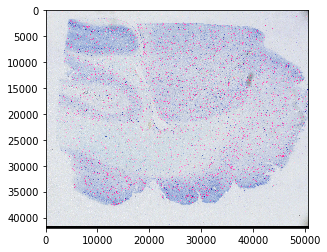

In [23]:
plt.imshow(stiched_op_img)

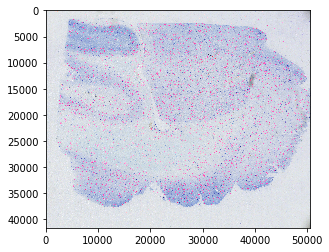

In [24]:
plt.imshow(stiched_op_img[:H,:W,:])

In [25]:
# import numpy as np
# import tifffile

# Assuming you have an image array (numpy array) named 'image_array'

# Specify the file path and name for the output TIFF file
saving_start=time.time()
output_file = "/M32/Samik/ImageTiles/segmented_output_0172.tif"

# Write the image array as a TIFF file
imsave(output_file, stiched_op_img[:H,:W,:])
saving_end=time.time()
saving_time=(saving_end-saving_start)/60
print("TIFF file saved successfully.")
print("Image Saving time: ",saving_time," minutes.")

TIFF file saved successfully.
Image Saving time:  1.0809000293413797  minutes.


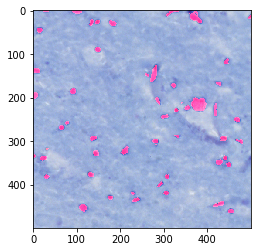

In [26]:
plt.imshow(imread(output_file)[5000:5500,5000:5500,:])

In [27]:
print("Total Running time of this ipynb (Reading, Saving and viewing the inferenced image) is: ",(saving_end-start_time)/60, " minutes.")

Total Running time of this ipynb (Reading, Saving and viewing the inferenced image) is:  116.43822588920594  minutes.


In [28]:
print("Total Image processing Time: ", read_time+inferencing_time+(stitching_time/60)+saving_time," minutes.")




Total Image processing Time:  104.20625463724136  minutes.
